In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_error, roc_auc_score, precision_score, make_scorer, accuracy_score
from sklearn.linear_model import LassoCV, Lasso, LassoLarsIC, ElasticNet, LassoLarsCV
from sklearn.externals import joblib
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import inspect
import math
pd.set_option('display.max_rows', 10000)

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Importing data, no TSS normalization performed here

In [4]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples that grouped with controls on PCoA

In [5]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

## Seperate general model validation bodies and training bodies

In [6]:
allMetab_train = allMetab.filter_samples('validation_set', 'n')
allMetab_val = allMetab.filter_samples('validation_set', 'y')

In [7]:
allMetab_train.sample_metadata.description.value_counts()

skin.hip    497
soil.hip    493
Name: description, dtype: int64

In [8]:
allMetab_val.sample_metadata.description.value_counts()

soil.hip    251
skin.hip    249
Name: description, dtype: int64

In [9]:
#allMetab.sample_metadata.columns

In [10]:
#dir(allMetab)

In [11]:
#print(allMetab.feature_metadata)

# Split by sampling location skin v. soil)

## soil sample filtering

In [12]:
allMetab_soil = allMetab.filter_samples('sample_type', 'soil')
allMetab_soil.sample_metadata.sample_type.value_counts()

soil    744
Name: sample_type, dtype: int64

In [13]:
Metab_train_soil = allMetab_train.filter_samples('sample_type', 'soil')
Metab_train_soil.sample_metadata.sample_type.value_counts()

soil    493
Name: sample_type, dtype: int64

In [14]:
Metab_val_soil = allMetab_val.filter_samples('sample_type', 'soil')
Metab_val_soil.sample_metadata.sample_type.value_counts()

soil    251
Name: sample_type, dtype: int64

# Soil General Model of Facilities and Season using ADD 0C as Response and Adding Metadata

In [15]:
Metab_train_soil_meta = Metab_train_soil.add_sample_metadata_as_features(['season','facility','avg_percent_humidity','total_precipitation_cm'])

#print(Metab_train_soil_meta.feature_metadata)

In [16]:
#model_Metab_soil_meta = joblib.load('models/PMI3_Metab_soil_meta_general.pkl')

In [17]:
#model_Metab_soil_meta

## Recursive Feature Elimination 

In [18]:
#model_Metab_soil_meta_rfecv = joblib.load('models/PMI3_Metab_soil_meta_general_rfecv.pkl')
#model_Metab_soil_meta_rfecv

## Testing on validaiton set

In [19]:
Metab_val_soil_meta = Metab_val_soil.add_sample_metadata_as_features(['season','facility','avg_percent_humidity','total_precipitation_cm'])

# Soil General Model of Facilities and Season using ADD 0C as Response without Metadata

In [20]:
#model_Metab_soil = joblib.load('models/PMI3_Metab_soil_general.pkl')

In [21]:
#model_Metab_soil

## Recursive Feature Elimination 

In [22]:
#model_Metab_soil_rfecv = joblib.load('models/PMI3_Metab_soil_general_rfecv.pkl')
#model_Metab_soil_rfecv

# Splitting data by facility with full soil dataset

## Training set CMU model

In [23]:
Metab_train_soil_CMU = Metab_train_soil.filter_samples('facility', 'CMU')
Metab_train_soil_CMU.sample_metadata.facility.value_counts()

CMU    162
Name: facility, dtype: int64

In [24]:
Metab_train_soil_CMU.sample_metadata.subjectID.value_counts()

17-10             21
CMU_Mrs._16_05    21
Mrs. 17-01        21
CMU_Mr._16_04     21
17-12             21
16-12             20
Mr 17-04          20
Mrs. 16-10        17
Name: subjectID, dtype: int64

In [25]:
Metab_train_soil_CMU_meta = Metab_train_soil_CMU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

gkf = GroupKFold(4)

X_CMU_train = Metab_train_soil_CMU_meta.data
y_CMU_train = Metab_train_soil_CMU_meta.sample_metadata['add_0c']
y_CMU_train = (y_CMU_train.astype(float))
groups = Metab_train_soil_CMU_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
#
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [4],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01], 
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=1000, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_CMU_train, y_CMU_train, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [25]:
gs.fit(X_CMU_train, y_CMU_train)

KeyboardInterrupt: 

In [ ]:
print(gs.best_params_)

In [26]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('CMU_soil_train_meta\t'+str(round(-gs.best_score_,2))+'\n')
out.close

The best mean error rate is 80.31


<function TextIOWrapper.close()>

In [27]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_CMU_soil_train.pkl')

['models/PMI3_Metab_CMU_skin_train.pkl']

In [26]:
model_Metab_CMU_train = joblib.load('models/PMI3_Metab_CMU_soil_train.pkl')

In [27]:
model_Metab_CMU_train

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=4, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.001, min_weight_fraction_leaf=0.01,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [31]:
rfecv = RFECV(estimator=model_Metab_CMU_train, step=0.05, min_features_to_select=100, cv=list(gkf.split(X_CMU_train, y_CMU_train, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [32]:
# Likely need to run on Summit
rfecv.fit(X_CMU_train, y_CMU_train)

RFECV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  50,  51,  52,  53,  54,  55,  56,  57,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130...
                                      max_features=0.1, max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1,
                                      min_samples_split=0.001,
                             

In [33]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 21
Optimal number of features : 1106
The best mean absolute error is: 84


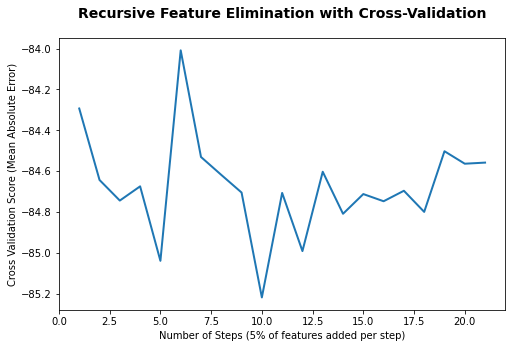

In [34]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/CMU_soil_train_model_rfecv.png')

In [35]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_soil_CMU_train_rfecv.pkl')

['models/PMI3_Metab_soil_CMU_train_rfecv.pkl']

In [36]:
model_Metab_CMU_train_rfecv = joblib.load('models/PMI3_Metab_soil_CMU_train_rfecv.pkl')
model_Metab_CMU_train_rfecv

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=4, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.001, min_weight_fraction_leaf=0.01,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

### Predicting training data (will be overfit but good sanity check)

In [37]:
# Removes the unimportant features from X
X_CMU_train = rfecv.transform(X_CMU_train)

yhat = model_Metab_CMU_train_rfecv.predict(X_CMU_train)
MAE = mean_absolute_error(y_CMU_train, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')

#Score of best estimator when used to estimate training data (will be overfit)
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_CMU_train_rfecv.score(X_CMU_train,y_CMU_train),2))

Mean Absolute Error: 41.44 ADD
Coefficient of determination R^2 of the prediction: 0.69


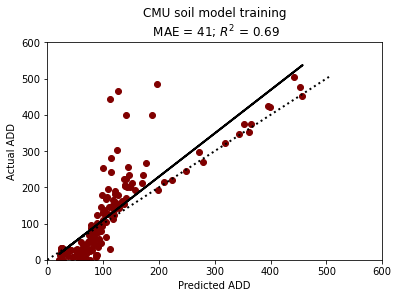

In [38]:
plt.scatter(yhat, y_CMU_train, color = 'maroon')
lower = np.min(np.concatenate([y_CMU_train, yhat]))
upper = np.max(np.concatenate([y_CMU_train, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_CMU_train)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('CMU soil model training\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_CMU_train_rfecv.score(X_CMU_train,y_CMU_train),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/CMU_soil_model_training.png')

### Determine important features after RFECV

In [39]:
importances = model_Metab_CMU_train_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_CMU_train_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_train_soil_CMU_meta.feature_metadata
np.savetxt("feature_metadata/CMU_soil_train_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
soil_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    soil_importances += (Metab_train_soil_CMU_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_train_soil_CMU_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. avg_percent_humidity	0.06265019697580822
2. X277.213423203688_7.13919135897436	0.046285196621838845
3. X263.150715332031_2.50629	0.03946083159436166
4. X237.220427340176_7.13047029360967	0.03913890155919208
5. X282.27712487174_7.23317913752913	0.03225068657357482
6. X303.122259140014_2.14927765151515	0.025608160029543435
7. X669.93791489374_6.24358174603174	0.02304683026810206
8. X295.225746885259_6.09304465868794	0.02246022731194898
9. X223.128096923828_3.35722466666666	0.02170638261487138
10. X285.121890324418_5.01388440860215	0.02065139187732148
11. X237.109812484962_3.76709734299517	0.019686386693104078
12. X278.189859650704_4.10320385434824	0.017556411700084075
13. X349.182713635225_2.28818164492197	0.01674281050772427
14. X335.218267234412_5.24703085612366	0.016299782139217834
15. X393.20879965785_2.43590272289767	0.01424167247929842
16. X269.17245213132_3.96002475399754	0.01378585552432046
17. X353.22884937712_4.15044508410328	0.01364333536937131
18. X

In [40]:
# make sure shape is right
print("Number of features present:", int(len(soil_importances)/2))
soil_importances_df = pd.DataFrame(np.array(soil_importances).reshape(int(len(soil_importances)/2),2))

np.savetxt("importances/CMU_soil_train_importances.csv", soil_importances_df, delimiter=",", fmt='%s')

Number of features present: 1106


## Testing on validaiton set

In [41]:
Metab_val_soil_CMU = Metab_val_soil.filter_samples('facility', 'CMU')
Metab_val_soil_CMU.sample_metadata.facility.value_counts()

CMU    83
Name: facility, dtype: int64

In [42]:
Metab_val_soil_CMU_meta = Metab_val_soil_CMU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

In [43]:
X_CMU_val = rfecv.transform(Metab_val_soil_CMU_meta.data) #removing the unimportant features from X as determined by RFECV
y_CMU_val = Metab_val_soil_CMU_meta.sample_metadata['add_0c']
y_CMU_val = (y_CMU_val.astype(float))

yhat = model_Metab_CMU_train_rfecv.predict(X_CMU_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_CMU_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_CMU_train_rfecv.score(X_CMU_val,y_CMU_val),2))

with open('soil_model_errors.txt', 'a') as out:
    out.write('CMU_soil_train_pred_val\t'+str(round(MAE, 2))+'\t'+str(round(model_Metab_CMU_train_rfecv.score(X_CMU_val,y_CMU_val),2))+'\n')
out.close

Mean Absolute Error: 76.92 ADD
Coefficient of determination R^2 of the prediction: 0.38


<function TextIOWrapper.close()>

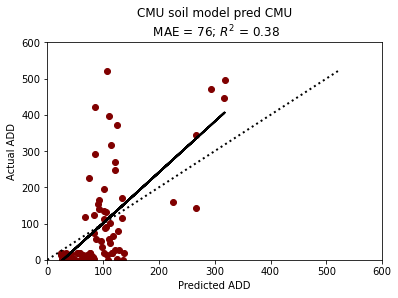

In [44]:
plt.scatter(yhat, y_CMU_val, color = 'maroon')
lower = np.min(np.concatenate([y_CMU_val, yhat]))
upper = np.max(np.concatenate([y_CMU_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_CMU_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('CMU soil model pred CMU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_CMU_train_rfecv.score(X_CMU_val,y_CMU_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/CMU_soil_model_validation.png')

## Full CMU model

In [53]:
Metab_CMU = allMetab_soil.filter_samples('facility', 'CMU')
Metab_CMU.sample_metadata.facility.value_counts()

CMU    248
Name: facility, dtype: int64

In [45]:
Metab_CMU.sample_metadata.subjectID.value_counts()

17-12             21
17-10             21
Mr 17-04          21
16-14             21
Mrs. 17-01        21
CMU_Mr._16_04     21
CMU_Mrs._16_03    21
Mr. 16-15         21
Mrs. 16-09        21
CMU_Mrs._16_05    21
16-12             21
Mrs. 16-10        17
Name: subjectID, dtype: int64

In [56]:
Metab_CMU_meta = Metab_CMU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

gkf = GroupKFold(4)

X_CMU = Metab_CMU_meta.data
y_CMU = Metab_CMU_meta.sample_metadata['add_0c']
y_CMU = (y_CMU.astype(float))
groups = Metab_CMU_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [4],
          "max_features": [0.1],
          "min_samples_split": [0.1],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=1000, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_CMU, y_CMU, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


In [47]:
gs.fit(X_CMU, y_CMU)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x11c8507c8>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [48]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('CMU_soil_meta\t'+str(round(-gs.best_score_,2))+'\n')
out.close

The best mean error rate is 63.1


<function TextIOWrapper.close()>

In [49]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_CMU_soil.pkl')

['models/PMI3_Metab_CMU_skin_rfecv.pkl']

In [54]:
model_Metab_CMU = joblib.load('models/PMI3_Metab_CMU_soil.pkl')

In [55]:
model_Metab_CMU

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=4,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [52]:
rfecv = RFECV(estimator=model_Metab_CMU, step=0.05, min_features_to_select=100, cv=list(gkf.split(X_CMU, y_CMU, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [53]:
# Likely need to run on Summit
rfecv.fit(X_CMU, y_CMU)

RFECV(cv=[(array([  0,   1, ..., 246, 247]), array([  8,   9,  10,  11,  12,  13,  14,  15,  24,  25,  26,  27,  28,
        43,  44,  45,  46,  48,  49,  50,  51,  83,  84,  85,  86,  87,
        88,  91,  92,  93,  94,  95,  96,  97, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 200... 161, 162, 163, 167, 168, 169, 170, 171, 172, 190, 207,
       208, 209, 210, 211, 212, 213, 245]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [54]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 1766
The best mean absolute error is: 59


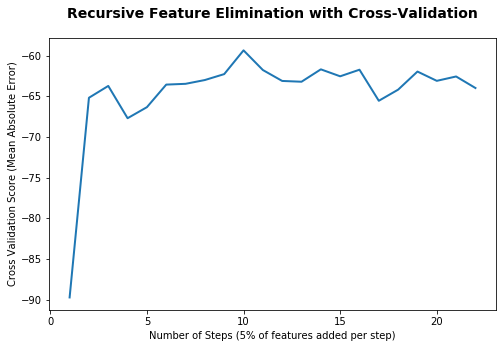

In [55]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/CMU_soil_model_rfecv.png')

In [56]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_soil_CMU_rfecv.pkl')

['models/PMI3_Metab_skin_CMU_rfecv.pkl']

In [57]:
model_Metab_CMU_rfecv = joblib.load('models/PMI3_Metab_soil_CMU_rfecv.pkl')
model_Metab_CMU_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=4,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Determine important features after RFECV

In [58]:
importances = model_Metab_CMU_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_CMU_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_CMU_meta.feature_metadata
np.savetxt("feature_metadata/CMU_soil_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
soil_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    soil_importances += (Metab_CMU_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_CMU_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X228.23079588292_6.35603299435028	0.08675024179674495
2. X326.340475453795_8.1965404290429	0.05799473021702757
3. X352.356264209747_8.29605718749999	0.046475206144069074
4. X237.220427340176_7.13047029360967	0.03910448875917925
5. X270.278182922606_7.326998937583	0.036326448264067834
6. X192.137958241932_3.81698134328358	0.03565494480802143
7. avg_percent_humidity	0.0308295265227053
8. X354.371857869256_8.7059326460481	0.030261610559464833
9. X324.292402283678_7.72840526528958	0.024841397562511875
10. X200.200297817107_5.5910755376344	0.024816493818120025
11. X338.340824997771_8.0974091286307	0.022593200485523747
12. X341.304059024148_7.978558685446	0.02245241077241888
13. X256.262006528934_7.07576439121756	0.022427031182844958
14. X412.304847263645_6.60969774774774	0.02163926827467066
15. X254.247322840048_6.55874982269503	0.021536004545871228
16. X151.079256772994_3.4678234375	0.015206945075772292
17. X311.254663848876_6.79568055555555	0.014225340222266101


In [59]:
# make sure shape is right
print("Number of features present:", int(len(soil_importances)/2))
soil_importances_df = pd.DataFrame(np.array(soil_importances).reshape(int(len(soil_importances)/2),2))

np.savetxt("importances/CMU_soil_importances.csv", soil_importances_df, delimiter=",", fmt='%s')

Number of features present: 3526


## Cross-facility predictions

## CMU trained model
### Test on SHSU

In [60]:
rfecv.transform(X_CMU).shape

(248, 1766)

In [61]:
Metab_SHSU = allMetab_soil.filter_samples('facility', 'SHSU')
Metab_SHSU_meta = Metab_SHSU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])
rfecv.transform(Metab_SHSU_meta.data).shape

/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


(249, 1766)

In [62]:
yhat = model_Metab_CMU_rfecv.predict(rfecv.transform(Metab_SHSU_meta.data))

In [63]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_SHSU_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_SHSU_meta.data),Metab_SHSU_meta.sample_metadata['add_0c'].astype(float)),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('CMU_soil_model_pred_SHSU_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_SHSU_meta.data),Metab_SHSU_meta.sample_metadata['add_0c'].astype(float)),2))+'\n')
out.close

Mean Absolute Error: 85.85 ADD
Coefficient of determination R^2 of the prediction: 0.33


<function TextIOWrapper.close()>

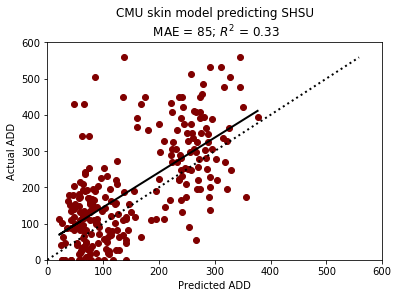

In [64]:
plt.scatter(yhat, Metab_SHSU_meta.sample_metadata.add_0c, color = 'maroon')
lower = np.min(np.concatenate([Metab_SHSU_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_SHSU_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_SHSU_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('CMU soil model predicting SHSU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_SHSU_meta.data),Metab_SHSU_meta.sample_metadata['add_0c'].astype(float)),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/CMU_soil_model_pred_SHSU.png')

### Test on UTK

In [65]:
rfecv.transform(X_CMU).shape

(248, 1766)

In [66]:
Metab_UTK = allMetab_soil.filter_samples('facility', 'UTK')
Metab_UTK_meta = Metab_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])
rfecv.transform(Metab_UTK_meta.data).shape

(249, 1766)

In [67]:
yhat = model_Metab_CMU_rfecv.predict(rfecv.transform(Metab_UTK_meta.data))

In [68]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_UTK_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_UTK_meta.data),Metab_UTK_meta.sample_metadata['add_0c'].astype(float)),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('CMU_soil_model_pred_UTK_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_UTK_meta.data),Metab_UTK_meta.sample_metadata['add_0c'].astype(float)),2))+'\n')
out.close

Mean Absolute Error: 68.79 ADD
Coefficient of determination R^2 of the prediction: 0.44


<function TextIOWrapper.close()>

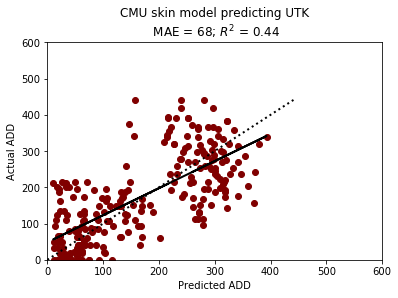

In [69]:
plt.scatter(yhat, Metab_UTK_meta.sample_metadata.add_0c, color = 'maroon')
lower = np.min(np.concatenate([Metab_UTK_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_UTK_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_UTK_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('CMU soil model predicting UTK\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_UTK_meta.data),Metab_UTK_meta.sample_metadata['add_0c'].astype(float)),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/CMU_soil_model_pred_UTK.png')

### Test on SHSU and UTK

In [70]:
Metab_SHSU_UTK = allMetab_soil.filter_samples('facility','CMU', negate = True)
Metab_SHSU_UTK_meta = Metab_SHSU_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

X_SHSU_UTK = Metab_SHSU_UTK_meta.data
y_SHSU_UTK = Metab_SHSU_UTK_meta.sample_metadata['add_0c'].astype(float)
Metab_SHSU_UTK_meta.sample_metadata.facility.value_counts()

SHSU    499
UTK     498
Name: facility, dtype: int64

In [71]:
rfecv.transform(X_CMU).shape

(248, 1766)

In [72]:
rfecv.transform(Metab_SHSU_UTK_meta.data).shape

(997, 1766)

In [73]:
yhat = model_Metab_CMU_rfecv.predict(rfecv.transform(Metab_SHSU_UTK_meta.data))

In [74]:
#yhat

In [75]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_SHSU_UTK_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_SHSU_UTK_meta.data),y_SHSU_UTK),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('CMU_soil_model_pred_SHSU_UTK_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_SHSU_UTK_meta.data),y_SHSU_UTK),2))+'\n')
out.close

Mean Absolute Error: 95.83 ADD
Coefficient of determination R^2 of the prediction: -0.01


<function TextIOWrapper.close()>

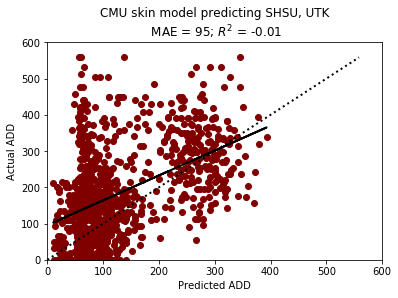

In [76]:
plt.scatter(yhat, Metab_SHSU_UTK_meta.sample_metadata.add_0c, color = 'maroon')
lower = np.min(np.concatenate([Metab_SHSU_UTK_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_SHSU_UTK_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_SHSU_UTK_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('CMU soil model predicting SHSU, UTK\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_CMU_rfecv.score(rfecv.transform(Metab_SHSU_UTK_meta.data),y_SHSU_UTK),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/CMU_soil_model_pred_SHSU_UTK.png')

## Training set SHSU model

In [77]:
Metab_train_soil_SHSU = Metab_train_soil.filter_samples('facility', 'SHSU')
Metab_train_soil_SHSU.sample_metadata.facility.value_counts()

SHSU    166
Name: facility, dtype: int64

In [78]:
Metab_train_soil_SHSU.sample_metadata.subjectID.value_counts()

shsu.2016.007    21
2016.065         21
2017.043         21
2017.045         21
2016.064         21
shsu.2016.024    21
2016.076         21
2016.072         19
Name: subjectID, dtype: int64

In [79]:
Metab_train_soil_SHSU_meta = Metab_train_soil_SHSU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

gkf = GroupKFold(4)

X_SHSU_train = Metab_train_soil_SHSU_meta.data
y_SHSU_train = Metab_train_soil_SHSU_meta.sample_metadata['add_0c']
y_SHSU_train = (y_SHSU_train.astype(float))
groups = Metab_train_soil_SHSU_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
          
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [4],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01], 
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=1000, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_SHSU_train, y_SHSU_train, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [80]:
gs.fit(X_SHSU_train, y_SHSU_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x11dad5138>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [81]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('SHSU_soil_train_meta\t'+str(round(-gs.best_score_,2))+'\n')
out.close

The best mean error rate is 82.35


<function TextIOWrapper.close()>

In [82]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_SHSU_soil_train.pkl')

['models/PMI3_Metab_SHSU_skin_train.pkl']

In [83]:
model_Metab_SHSU_train = joblib.load('models/PMI3_Metab_SHSU_soil_train.pkl')

In [84]:
model_Metab_SHSU_train

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [85]:
rfecv = RFECV(estimator=model_Metab_SHSU_train, step=0.05, min_features_to_select=100, cv=list(gkf.split(X_SHSU_train, y_SHSU_train, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [86]:
# Likely need to run on Summit
rfecv.fit(X_SHSU_train, y_SHSU_train)

RFECV(cv=[(array([  0,   1, ..., 164, 165]), array([  7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  25,  26,
        27,  38,  39,  40,  41,  42,  43,  44,  45,  46,  72,  74,  75,
        76,  77,  78,  79, 114, 115, 137, 144, 145, 146, 155, 156, 160,
       161, 162, 163])), (array([  7,   8, .....67,  68,  69,
        70,  71,  73,  83,  84,  85,  86,  87,  88,  89, 118, 119, 138,
       139]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [87]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 2206
The best mean absolute error is: 76


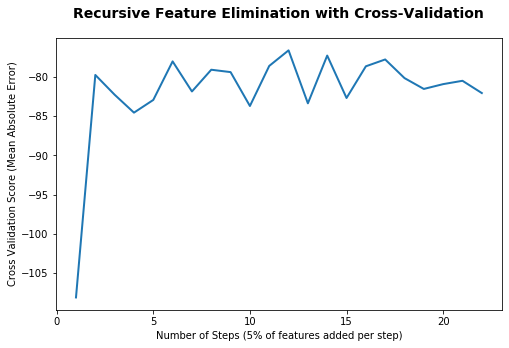

In [88]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/SHSU_soil_train_model_rfecv.png')

In [89]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_soil_SHSU_train_rfecv.pkl')

['models/PMI3_Metab_skin_SHSU_train_rfecv.pkl']

In [90]:
model_Metab_SHSU_train_rfecv = joblib.load('models/PMI3_Metab_soil_SHSU_train_rfecv.pkl')
model_Metab_SHSU_train_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Predicting training data (will be overfit but good sanity check)

In [91]:
# Removes the unimportant features from X
X_SHSU_train = rfecv.transform(X_SHSU_train)

yhat = model_Metab_SHSU_train_rfecv.predict(X_SHSU_train)
MAE = mean_absolute_error(y_SHSU_train, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')

#Score of best estimator when used to estimate training data (will be overfit)
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_SHSU_train_rfecv.score(X_SHSU_train,y_SHSU_train),2))

Mean Absolute Error: 13.88 ADD
Coefficient of determination R^2 of the prediction: 0.98


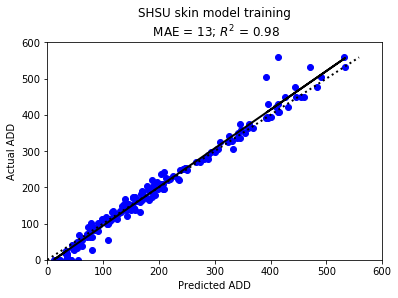

In [92]:
plt.scatter(yhat, y_SHSU_train, color = 'b')
lower = np.min(np.concatenate([y_SHSU_train, yhat]))
upper = np.max(np.concatenate([y_SHSU_train, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_SHSU_train)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('SHSU soil model training\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_SHSU_train_rfecv.score(X_SHSU_train,y_SHSU_train),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/SHSU_soil_model_training.png')

### Determine important features after RFECV

In [93]:
importances = model_Metab_SHSU_train_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_SHSU_train_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_train_soil_SHSU_meta.feature_metadata
np.savetxt("feature_metadata/SHSU_soil_train_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
soil_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    soil_importances += (Metab_train_soil_SHSU_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_train_soil_SHSU_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X358.292639041769_4.70101408045976	0.0682349281703848
2. X270.278182922606_7.326998937583	0.05516410261490262
3. X633.463031115832_6.35839249249249	0.043432938451175115
4. X352.356264209747_8.29605718749999	0.03977484495942609
5. X254.247322840048_6.55874982269503	0.038314822946864516
6. X237.220427340176_7.13047029360967	0.029282177852632003
7. X282.27712487174_7.23317913752913	0.027688629832600693
8. X802.587084562882_7.45415217391304	0.025780976668312434
9. X362.30250113351_7.11766666666666	0.02524353000546955
10. X362.247869603774_5.52714950980392	0.021389421888775084
11. X419.227672576904_3.86399479166666	0.019205770855381245
12. X360.179552706805_6.08574106297349	0.014173833581383239
13. X319.223587733443_5.90276478494623	0.01219877374957613
14. X326.340475453795_8.1965404290429	0.011352439517648392
15. X281.246455416747_6.20061735953641	0.010681913304503136
16. X241.105193080902_2.83643516666666	0.010494756559078259
17. X367.334885250438_7.964863825757

In [94]:
# make sure shape is right
print("Number of features present:", int(len(soil_importances)/2))
soil_importances_df = pd.DataFrame(np.array(soil_importances).reshape(int(len(soil_importances)/2),2))

np.savetxt("importances/SHSU_soil_train_importances.csv", soil_importances_df, delimiter=",", fmt='%s')

Number of features present: 2206


## Testing on validaiton set

In [95]:
Metab_val_soil_SHSU = Metab_val_soil.filter_samples('facility', 'SHSU')
Metab_val_soil_SHSU.sample_metadata.facility.value_counts()

SHSU    83
Name: facility, dtype: int64

In [96]:
Metab_val_soil_SHSU_meta = Metab_val_soil_SHSU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


In [97]:
X_SHSU_val = rfecv.transform(Metab_val_soil_SHSU_meta.data) #removing the unimportant features from X as determined by RFECV
y_SHSU_val = Metab_val_soil_SHSU_meta.sample_metadata['add_0c']
y_SHSU_val = (y_SHSU_val.astype(float))

yhat = model_Metab_SHSU_train_rfecv.predict(X_SHSU_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_SHSU_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_SHSU_train_rfecv.score(X_SHSU_val,y_SHSU_val),2))

with open('soil_model_errors.txt', 'a') as out:
    out.write('SHSU_soil_train_pred_val\t'+str(round(MAE, 2))+'\t'+str(round(model_Metab_SHSU_train_rfecv.score(X_SHSU_val,y_SHSU_val),2))+'\n')
out.close

Mean Absolute Error: 78.72 ADD
Coefficient of determination R^2 of the prediction: 0.48


<function TextIOWrapper.close()>

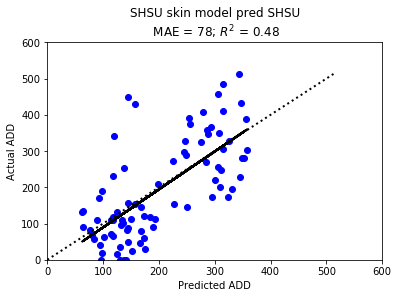

In [98]:
plt.scatter(yhat, y_SHSU_val, color = 'b')
lower = np.min(np.concatenate([y_SHSU_val, yhat]))
upper = np.max(np.concatenate([y_SHSU_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_SHSU_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('SHSU soil model pred SHSU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_SHSU_train_rfecv.score(X_SHSU_val,y_SHSU_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/SHSU_soil_model_validation.png')

## Full SHSU model

In [99]:
Metab_SHSU = allMetab_soil.filter_samples('facility', 'SHSU')
Metab_SHSU.sample_metadata.facility.value_counts()

SHSU    249
Name: facility, dtype: int64

In [100]:
Metab_SHSU.sample_metadata.subjectID.value_counts()

2017.045         21
2016.073         21
2016.065         21
shsu.2016.011    21
2016.067         21
shsu.2016.007    21
2017.043         21
2016.064         21
shsu.2016.024    21
2016.076         21
2017.046         20
2016.072         19
Name: subjectID, dtype: int64

In [101]:
Metab_SHSU_meta = Metab_SHSU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

gkf = GroupKFold(4)

X_SHSU = Metab_SHSU_meta.data
y_SHSU = Metab_SHSU_meta.sample_metadata['add_0c']
y_SHSU = (y_SHSU.astype(float))
groups = Metab_SHSU_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
          
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [4],
          "max_features": [0.1],
          "min_samples_split": [0.001],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=1000, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_SHSU, y_SHSU, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [102]:
gs.fit(X_SHSU, y_SHSU)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x11dad5f48>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [103]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('SHSU_soil_meta\t'+str(round(-gs.best_score_,2))+'\n')
out.close

The best mean error rate is 77.82


<function TextIOWrapper.close()>

In [104]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_SHSU_soil.pkl')

['models/PMI3_Metab_SHSU_skin_rfecv.pkl']

In [105]:
model_Metab_SHSU = joblib.load('models/PMI3_Metab_SHSU_soil.pkl')

In [106]:
model_Metab_SHSU

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [107]:
rfecv = RFECV(estimator=model_Metab_SHSU, step=0.05, min_features_to_select=100, cv=list(gkf.split(X_SHSU, y_SHSU, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [108]:
# Likely need to run on Summit
rfecv.fit(X_SHSU, y_SHSU)

RFECV(cv=[(array([  0,   1, ..., 247, 248]), array([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  38,  39,
        40,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86, 127, 128,
       129, 130, 131, 132, 133, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 175, 176, 179, 180, 181... 165, 169, 170, 177, 178, 194, 195, 196, 197,
       198, 199, 200, 230, 231, 232, 233, 234, 235]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [109]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 4406
The best mean absolute error is: 77


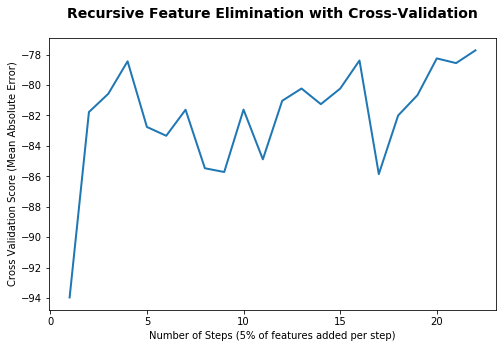

In [110]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/SHSU_soil_model_rfecv.png')

In [111]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_soil_SHSU_rfecv.pkl')

['models/PMI3_Metab_skin_SHSU_rfecv.pkl']

In [112]:
model_Metab_SHSU_rfecv = joblib.load('models/PMI3_Metab_soil_SHSU_rfecv.pkl')
model_Metab_SHSU_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Determine important features after RFECV

In [113]:
importances = model_Metab_SHSU_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_SHSU_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_SHSU_meta.feature_metadata
np.savetxt("feature_metadata/SHSU_soil_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
soil_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    soil_importances += (Metab_SHSU_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_SHSU_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X265.251786739268_6.47317440898345	0.14289585120825557
2. X228.23079588292_6.35603299435028	0.055252916384917326
3. X358.292639041769_4.70101408045976	0.05273672167373594
4. X352.356264209747_8.29605718749999	0.04379731177358379
5. X326.340475453795_8.1965404290429	0.040753695278260366
6. X254.247322840048_6.55874982269503	0.03944806732499246
7. X270.278182922606_7.326998937583	0.03834129307611079
8. X557.454941275734_5.91205104821803	0.03745486638974715
9. avg_percent_humidity	0.011787079448321228
10. X338.340748569973_8.40681924398625	0.010533398448116307
11. X229.14363035979_3.80993827160493	0.00961717443338459
12. X298.273786351693_7.60156672587329	0.008089711288630227
13. X315.28826453469_7.8770824810606	0.007998710893764225
14. X175.096391116217_2.62781174684159	0.007451685492176165
15. X421.146735428364_3.97134832028701	0.007100109340365692
16. X343.293593163583_4.6008931372549	0.006842233957803789
17. X259.189956798888_5.46824700292397	0.0065945681698

In [114]:
# make sure shape is right
print("Number of features present:", int(len(soil_importances)/2))
soil_importances_df = pd.DataFrame(np.array(soil_importances).reshape(int(len(soil_importances)/2),2))

np.savetxt("importances/SHSU_soil_importances.csv", soil_importances_df, delimiter=",", fmt='%s')

Number of features present: 4406


## Cross-facility predictions

## SHSU trained model
### Test on CMU

In [115]:
rfecv.transform(X_SHSU).shape

(249, 4406)

In [116]:
Metab_CMU = allMetab_soil.filter_samples('facility', 'CMU')
Metab_CMU_meta = Metab_CMU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])
rfecv.transform(Metab_CMU_meta.data).shape

/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


(248, 4406)

In [117]:
yhat = model_Metab_SHSU_rfecv.predict(rfecv.transform(Metab_CMU_meta.data))

In [118]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_CMU_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_CMU_meta.data),Metab_CMU_meta.sample_metadata['add_0c'].astype(float)),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('SHSU_soil_model_pred_CMU_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_CMU_meta.data),Metab_CMU_meta.sample_metadata['add_0c'].astype(float)),2))+'\n')
out.close

Mean Absolute Error: 84.06 ADD
Coefficient of determination R^2 of the prediction: 0.42


<function TextIOWrapper.close()>

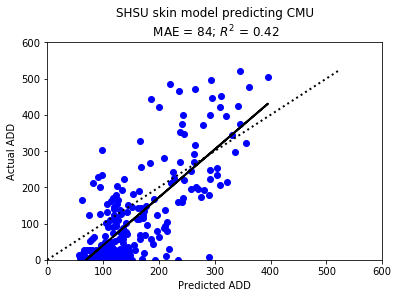

In [119]:
plt.scatter(yhat, Metab_CMU_meta.sample_metadata.add_0c, color = 'b')
lower = np.min(np.concatenate([Metab_CMU_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_CMU_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_CMU_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('SHSU soil model predicting CMU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_CMU_meta.data),Metab_CMU_meta.sample_metadata['add_0c'].astype(float)),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/SHSU_soil_model_pred_CMU.png')

### Test on UTK

In [120]:
rfecv.transform(X_SHSU).shape

(249, 4406)

In [121]:
Metab_UTK = allMetab_soil.filter_samples('facility', 'UTK')
Metab_UTK_meta = Metab_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])
rfecv.transform(Metab_UTK_meta.data).shape

(249, 4406)

In [122]:
yhat = model_Metab_SHSU_rfecv.predict(rfecv.transform(Metab_UTK_meta.data))

In [123]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_UTK_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_UTK_meta.data),Metab_UTK_meta.sample_metadata['add_0c'].astype(float)),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('SHSU_soil_model_pred_UTK_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_UTK_meta.data),Metab_UTK_meta.sample_metadata['add_0c'].astype(float)),2))+'\n')
out.close

Mean Absolute Error: 71.86 ADD
Coefficient of determination R^2 of the prediction: 0.48


<function TextIOWrapper.close()>

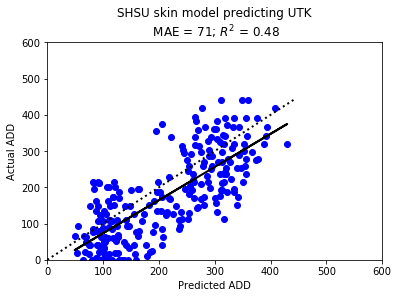

In [124]:
plt.scatter(yhat, Metab_UTK_meta.sample_metadata.add_0c, color = 'b')
lower = np.min(np.concatenate([Metab_UTK_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_UTK_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_UTK_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('SHSU soil model predicting UTK\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_UTK_meta.data),Metab_UTK_meta.sample_metadata['add_0c'].astype(float)),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/SHSU_soil_model_pred_UTK.png')

### Test on SHSU and UTK

In [125]:
Metab_CMU_UTK = allMetab_soil.filter_samples('facility','SHSU', negate = True)
Metab_CMU_UTK_meta = Metab_CMU_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

X_CMU_UTK = Metab_CMU_UTK_meta.data
y_CMU_UTK = Metab_CMU_UTK_meta.sample_metadata['add_0c'].astype(float)
Metab_CMU_UTK_meta.sample_metadata.facility.value_counts()

UTK    498
CMU    493
Name: facility, dtype: int64

In [126]:
rfecv.transform(X_SHSU).shape

(249, 4406)

In [127]:
rfecv.transform(Metab_CMU_UTK_meta.data).shape

(991, 4406)

In [128]:
yhat = model_Metab_SHSU_rfecv.predict(rfecv.transform(Metab_CMU_UTK_meta.data))

In [129]:
#yhat

In [130]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_CMU_UTK_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_CMU_UTK_meta.data),y_CMU_UTK),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('SHSU_soil_model_pred_CMU_UTK_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_CMU_UTK_meta.data),y_CMU_UTK),2))+'\n')
out.close

Mean Absolute Error: 84.01 ADD
Coefficient of determination R^2 of the prediction: 0.37


<function TextIOWrapper.close()>

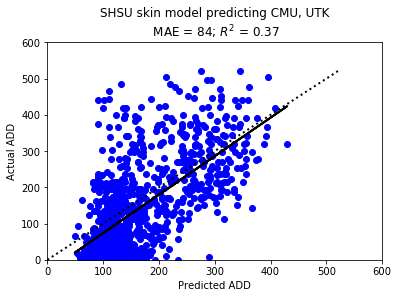

In [131]:
plt.scatter(yhat, Metab_CMU_UTK_meta.sample_metadata.add_0c, color = 'b')
lower = np.min(np.concatenate([Metab_CMU_UTK_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_CMU_UTK_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_CMU_UTK_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('SHSU soil model predicting CMU, UTK\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_SHSU_rfecv.score(rfecv.transform(Metab_CMU_UTK_meta.data),y_CMU_UTK),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/SHSU_soil_model_pred_CMU_UTK.png')

## Training set UTK model

In [132]:
Metab_train_soil_UTK = Metab_train_soil.filter_samples('facility', 'UTK')
Metab_train_soil_UTK.sample_metadata.facility.value_counts()

UTK    167
Name: facility, dtype: int64

In [133]:
Metab_train_soil_UTK.sample_metadata.subjectID.value_counts()

K016.09        21
UTK.K016.04    21
K016.07        21
UTK.K016.10    21
UTK.K016.01    21
UTK.K016.02    21
UTK.K016.05    21
UTK.K016.11    20
Name: subjectID, dtype: int64

In [134]:
Metab_train_soil_UTK_meta = Metab_train_soil_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

gkf = GroupKFold(4)

X_UTK_train = Metab_train_soil_UTK_meta.data
y_UTK_train = Metab_train_soil_UTK_meta.sample_metadata['add_0c']
y_UTK_train = (y_UTK_train.astype(float))
groups = Metab_train_soil_UTK_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
          
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [16],
          "max_features": [0.1],
          "min_samples_split": [0.1],
          "min_weight_fraction_leaf": [0.01], 
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=1000, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_UTK_train, y_UTK_train, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [135]:
gs.fit(X_UTK_train, y_UTK_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x11dbd18b8>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [136]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('UTK_soil_train_meta\t'+str(round(-gs.best_score_,2))+'\n')
out.close

The best mean error rate is 60.23


<function TextIOWrapper.close()>

In [137]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_UTK_soil_train.pkl')

['models/PMI3_Metab_UTK_skin_train.pkl']

In [138]:
model_Metab_UTK_train = joblib.load('models/PMI3_Metab_UTK_soil_train.pkl')

In [139]:
model_Metab_UTK_train

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [140]:
rfecv = RFECV(estimator=model_Metab_UTK_train, step=0.05, min_features_to_select=100, cv=list(gkf.split(X_UTK_train, y_UTK_train, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [141]:
# Likely need to run on Summit
rfecv.fit(X_UTK_train, y_UTK_train)

RFECV(cv=[(array([  0,  14, ..., 165, 166]), array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        28,  29,  30,  31,  32,  33,  34,  35,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94, 101, 102, 103, 109, 127, 128, 129,
       130, 143, 144])), (array([  0,   1, .....98,  99,
       100, 104, 105, 106, 107, 108, 110, 131, 132, 133, 134, 135, 136,
       137, 138]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [142]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 3746
The best mean absolute error is: 57


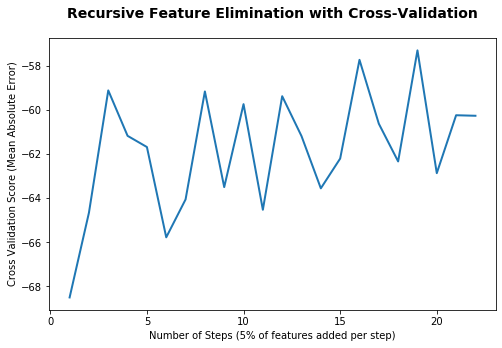

In [143]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/UTK_soil_train_model_rfecv.png')

In [144]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_soil_UTK_train_rfecv.pkl')

['models/PMI3_Metab_skin_UTK_train_rfecv.pkl']

In [145]:
model_Metab_UTK_train_rfecv = joblib.load('models/PMI3_Metab_soil_UTK_train_rfecv.pkl')
model_Metab_UTK_train_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Predicting training data (will be overfit but good sanity check)

In [146]:
# Removes the unimportant features from X
X_UTK_train = rfecv.transform(X_UTK_train)

yhat = model_Metab_UTK_train_rfecv.predict(X_UTK_train)
MAE = mean_absolute_error(y_UTK_train, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')

#Score of best estimator when used to estimate training data (will be overfit)
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_UTK_train_rfecv.score(X_UTK_train,y_UTK_train),2))

Mean Absolute Error: 7.53 ADD
Coefficient of determination R^2 of the prediction: 0.99


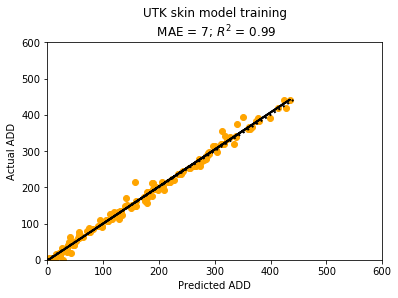

In [147]:
plt.scatter(yhat, y_UTK_train, color = 'orange')
lower = np.min(np.concatenate([y_UTK_train, yhat]))
upper = np.max(np.concatenate([y_UTK_train, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_UTK_train)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('UTK soil model training\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_UTK_train_rfecv.score(X_UTK_train,y_UTK_train),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/UTK_soil_model_training.png')

### Determine important features after RFECV

In [148]:
importances = model_Metab_UTK_train_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_UTK_train_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_train_soil_UTK_meta.feature_metadata
np.savetxt("feature_metadata/UTK_soil_train_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
soil_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    soil_importances += (Metab_train_soil_UTK_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_train_soil_UTK_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X358.292639041769_4.70101408045976	0.07527839286077136
2. X269.210000802471_5.71957425343018	0.06350844639825044
3. X346.257596826827_3.55504612923864	0.04317227133826041
4. X228.23079588292_6.35603299435028	0.04075199583960027
5. X235.205081385695_5.54213672199169	0.04004329953379722
6. X338.340824997771_8.0974091286307	0.03878120414636759
7. X593.475317968081_6.39350464231354	0.03866871749708479
8. X251.196778005923_5.72764201257861	0.03585650596376576
9. X313.271668434143_7.39331812499999	0.03240056729325981
10. X251.155228480819_3.34591225895317	0.019159351156469703
11. X323.254802010276_6.47503462121211	0.018031758292553022
12. X324.292402283678_7.72840526528958	0.01511940270479083
13. X470.380652618408_6.31804374999999	0.012770820418274976
14. X379.282191931683_6.98456826086956	0.011819304638010283
15. X279.230997695859_5.90311805903647	0.011106825654229203
16. X300.288733742453_4.75564670033669	0.010629309555868728
17. X255.231118649466_7.1240851116625

In [149]:
# make sure shape is right
print("Number of features present:", int(len(soil_importances)/2))
soil_importances_df = pd.DataFrame(np.array(soil_importances).reshape(int(len(soil_importances)/2),2))

np.savetxt("importances/UTK_soil_train_importances.csv", soil_importances_df, delimiter=",", fmt='%s')

Number of features present: 3746


## Testing on validaiton set

In [150]:
Metab_val_soil_UTK = Metab_val_soil.filter_samples('facility', 'UTK')
Metab_val_soil_UTK.sample_metadata.facility.value_counts()

UTK    82
Name: facility, dtype: int64

In [151]:
Metab_val_soil_UTK_meta = Metab_val_soil_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


In [152]:
X_UTK_val = rfecv.transform(Metab_val_soil_UTK_meta.data) #removing the unimportant features from X as determined by RFECV
y_UTK_val = Metab_val_soil_UTK_meta.sample_metadata['add_0c']
y_UTK_val = (y_UTK_val.astype(float))

yhat = model_Metab_UTK_train_rfecv.predict(X_UTK_val)

# cross-model error (cross-experiment error)
MAE = mean_absolute_error(y_UTK_val, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_UTK_train_rfecv.score(X_UTK_val,y_UTK_val),2))

with open('soil_model_errors.txt', 'a') as out:
    out.write('UTK_soil_train_pred_val\t'+str(round(MAE, 2))+'\t'+str(round(model_Metab_UTK_train_rfecv.score(X_UTK_val,y_UTK_val),2))+'\n')
out.close

Mean Absolute Error: 58.8 ADD
Coefficient of determination R^2 of the prediction: 0.55


<function TextIOWrapper.close()>

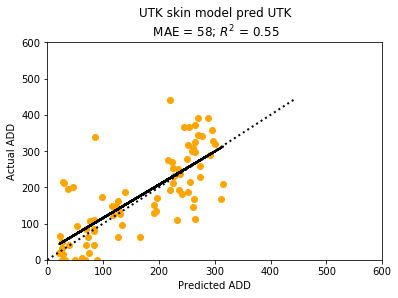

In [153]:
plt.scatter(yhat, y_UTK_val, color = 'orange')
lower = np.min(np.concatenate([y_UTK_val, yhat]))
upper = np.max(np.concatenate([y_UTK_val, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y_UTK_val)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('UTK soil model pred UTK\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_UTK_train_rfecv.score(X_UTK_val,y_UTK_val),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/UTK_soil_model_validation.png')

## Full UTK model

In [154]:
Metab_UTK = allMetab_soil.filter_samples('facility', 'UTK')
Metab_UTK.sample_metadata.facility.value_counts()

UTK    249
Name: facility, dtype: int64

In [155]:
Metab_UTK.sample_metadata.subjectID.value_counts()

UTK.K016.04    21
UTK.K016.03    21
K016.07        21
UTK.K016.01    21
UTK.K016.05    21
K016.09        21
UTK.K016.10    21
K016.08        21
UTK.K016.02    21
UTK.K016.12    20
UTK.K016.06    20
UTK.K016.11    20
Name: subjectID, dtype: int64

In [156]:
Metab_UTK_meta = Metab_UTK.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

gkf = GroupKFold(4)

X_UTK = Metab_UTK_meta.data
y_UTK = Metab_UTK_meta.sample_metadata['add_0c']
y_UTK = (y_UTK.astype(float))
groups = Metab_UTK_meta.sample_metadata['subjectID']
# Tested this param grid on Summit to expand hyperparameter tuning
#param_grid = {"max_depth": [4, 8, 16, None],
#              "max_features": ['sqrt', 'log2', 0.1],
#              "min_samples_split": [0.001, 0.01, 0.1],
#              "min_weight_fraction_leaf": [0.0001, 0.001, 0.01],
#              "bootstrap": [True, False]}
# It provided this best model:
          
# Takes too long to run on local computer; will need to run then import model from Summit

param_grid = {"max_depth": [None],
          "max_features": [0.1],
          "min_samples_split": [0.1],
          "min_weight_fraction_leaf": [0.01],
          "bootstrap": [False]}
rf = RandomForestRegressor(n_estimators=1000, random_state=999, criterion='mae')
gs = GridSearchCV(rf, param_grid=param_grid, cv=gkf.split(X_UTK, y_UTK, groups), scoring='neg_mean_absolute_error', n_jobs=-3)

In [157]:
gs.fit(X_UTK, y_UTK)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x11dfd1750>,
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8], 'max_features': [0.1], 'min_samples_split': [0.001], 'min_samples_leaf': [1], 'min_weight_fraction_leaf': [0.01], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [ ]:
print(gs.best_params_)

In [158]:
print('The best mean error rate is', round(-gs.best_score_,2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('UTK_soil_meta\t'+str(round(-gs.best_score_,2))+'\n')
out.close

The best mean error rate is 55.29


<function TextIOWrapper.close()>

In [159]:
joblib.dump(gs.best_estimator_, 'models/PMI3_Metab_UTK_soil.pkl')

['models/PMI3_Metab_UTK_skin_rfecv.pkl']

In [160]:
model_Metab_UTK = joblib.load('models/PMI3_Metab_UTK_soil.pkl')

In [161]:
model_Metab_UTK

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

## Recursive Feature Elimination 

### Uses the best estimator from the above model and performs 5% removal recursive steps

In [162]:
rfecv = RFECV(estimator=model_Metab_UTK, step=0.05, min_features_to_select=100, cv=list(gkf.split(X_UTK, y_UTK, groups)), scoring='neg_mean_absolute_error', n_jobs=-3)

In [163]:
# Likely need to run on Summit
rfecv.fit(X_UTK, y_UTK)

RFECV(cv=[(array([  1,   2, ..., 247, 248]), array([  0,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  51,  52,  53,  54,  55,  56,  67,  68,  69,  70,  71,
        72,  73,  74, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 126, 127, 128, 129, 130... 183, 184, 185, 209, 210, 211, 231, 232,
       233, 234, 241, 242, 243, 244, 245, 246, 247, 248]))],
   estimator=RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=0.05, verbose=0)

In [164]:
print("Number of steps performed: %d" % len(rfecv.grid_scores_))
print("Optimal number of features : %d" % rfecv.n_features_)
print("The best mean absolute error is: %d" % -(max(rfecv.grid_scores_)))

Number of steps performed: 22
Optimal number of features : 4186
The best mean absolute error is: 52


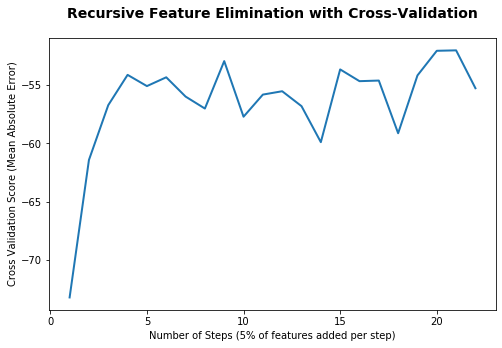

In [165]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Number of Steps (5% of features added per step)")
plt.ylabel("Cross Validation Score (Mean Absolute Error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=2)
plt.savefig('figures/UTK_soil_model_rfecv.png')

In [166]:
# Saves the estimator fit on the reduced dataset (i.e. the model created from optimal features)
joblib.dump(rfecv.estimator_, 'models/PMI3_Metab_soil_UTK_rfecv.pkl')

['models/PMI3_Metab_skin_UTK_rfecv.pkl']

In [167]:
model_Metab_UTK_rfecv = joblib.load('models/PMI3_Metab_soil_UTK_rfecv.pkl')
model_Metab_UTK_rfecv

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=8,
           max_features=0.1, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=0.001,
           min_weight_fraction_leaf=0.01, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=999, verbose=0, warm_start=False)

### Determine important features after RFECV

In [168]:
importances = model_Metab_UTK_rfecv.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_UTK_rfecv.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_UTK_meta.feature_metadata
np.savetxt("feature_metadata/UTK_soil_feature_metadata_rfecv.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
soil_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    soil_importances += (Metab_UTK_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_UTK_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X328.283489266621_6.07409948453607	0.08851098410893651
2. X235.205081385695_5.54213672199169	0.08664642940233411
3. X254.247322840048_6.55874982269503	0.07574080314135526
4. X228.23079588292_6.35603299435028	0.041533070732982555
5. X326.340475453795_8.1965404290429	0.0396552787344399
6. X283.261846131269_6.46965379294957	0.03922859010308807
7. X533.380648295084_8.47133075396825	0.03376337330552327
8. X213.148191867404_5.34548177777777	0.03313827997314662
9. X324.292402283678_7.72840526528958	0.021715832209273218
10. X549.380208996758_7.86295833333333	0.014847392735741954
11. X354.371857869256_8.7059326460481	0.011507381924343033
12. X269.210000802471_5.71957425343018	0.010649111695971384
13. X158.153798192113_4.34759069069069	0.009907260882806551
14. X605.308220987266_5.72433050847457	0.009149400048981396
15. X263.236333338818_7.31381844305119	0.007522129843750116
16. X419.348389998726_8.90823786231883	0.007461127000048751
17. X527.391812133789_7.856762638888

In [169]:
# make sure shape is right
print("Number of features present:", int(len(soil_importances)/2))
soil_importances_df = pd.DataFrame(np.array(soil_importances).reshape(int(len(soil_importances)/2),2))

np.savetxt("importances/UTK_soil_importances.csv", soil_importances_df, delimiter=",", fmt='%s')

Number of features present: 4186


## Cross-facility predictions

## UTK trained model
### Test on CMU

In [170]:
rfecv.transform(X_UTK).shape

(249, 4186)

In [171]:
Metab_CMU = allMetab_soil.filter_samples('facility', 'CMU')
Metab_CMU_meta = Metab_CMU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])
rfecv.transform(Metab_CMU_meta.data).shape

/Users/Zach/miniconda3/envs/ml/lib/python3.7/site-packages/calour/training.py:130: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  new.feature_metadata = pd.concat([pd.DataFrame(index=vec.get_feature_names()), new.feature_metadata])


(248, 4186)

In [172]:
yhat = model_Metab_UTK_rfecv.predict(rfecv.transform(Metab_CMU_meta.data))

In [173]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_CMU_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_CMU_meta.data),Metab_CMU_meta.sample_metadata['add_0c'].astype(float)),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('UTK_soil_model_pred_CMU_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_CMU_meta.data),Metab_CMU_meta.sample_metadata['add_0c'].astype(float)),2))+'\n')
out.close

Mean Absolute Error: 75.13 ADD
Coefficient of determination R^2 of the prediction: 0.38


<function TextIOWrapper.close()>

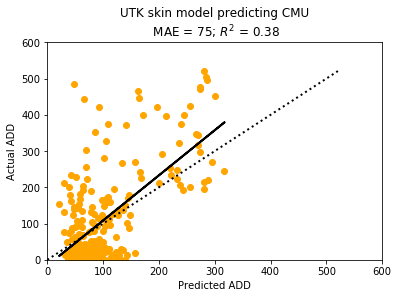

In [174]:
plt.scatter(yhat, Metab_CMU_meta.sample_metadata.add_0c, color = 'orange')
lower = np.min(np.concatenate([Metab_CMU_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_CMU_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_CMU_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('UTK soil model predicting CMU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_CMU_meta.data),Metab_CMU_meta.sample_metadata['add_0c'].astype(float)),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/UTK_soil_model_pred_CMU.png')

### Test on SHSU

In [175]:
rfecv.transform(X_UTK).shape

(249, 4186)

In [176]:
Metab_SHSU = allMetab_soil.filter_samples('facility', 'SHSU')
Metab_SHSU_meta = Metab_SHSU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])
rfecv.transform(Metab_SHSU_meta.data).shape

(249, 4186)

In [177]:
yhat = model_Metab_UTK_rfecv.predict(rfecv.transform(Metab_SHSU_meta.data))

In [178]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_SHSU_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_SHSU_meta.data),Metab_SHSU_meta.sample_metadata['add_0c'].astype(float)),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('UTK_soil_model_pred_SHSU_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_SHSU_meta.data),Metab_SHSU_meta.sample_metadata['add_0c'].astype(float)),2))+'\n')
out.close

Mean Absolute Error: 84.54 ADD
Coefficient of determination R^2 of the prediction: 0.27


<function TextIOWrapper.close()>

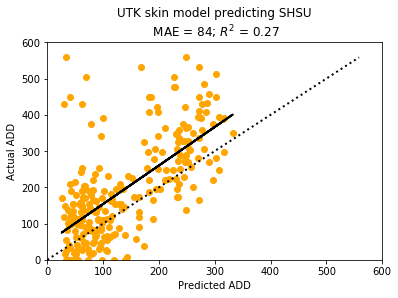

In [197]:
plt.scatter(yhat, Metab_SHSU_meta.sample_metadata.add_0c, color = 'orange')
lower = np.min(np.concatenate([Metab_SHSU_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_SHSU_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_SHSU_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('UTK soil model predicting SHSU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_SHSU_meta.data),Metab_SHSU_meta.sample_metadata['add_0c'].astype(float)),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/UTK_soil_model_pred_SHSU.png')

### Test on CMU and SHSU

In [180]:
Metab_CMU_SHSU = allMetab_soil.filter_samples('facility','UTK', negate = True)
Metab_CMU_SHSU_meta = Metab_CMU_SHSU.add_sample_metadata_as_features(['season','avg_percent_humidity','total_precipitation_cm'])

X_CMU_SHSU = Metab_CMU_SHSU_meta.data
y_CMU_SHSU = Metab_CMU_SHSU_meta.sample_metadata['add_0c'].astype(float)
Metab_CMU_SHSU_meta.sample_metadata.facility.value_counts()

SHSU    499
CMU     493
Name: facility, dtype: int64

In [181]:
rfecv.transform(X_UTK).shape

(249, 4186)

In [182]:
rfecv.transform(Metab_CMU_SHSU_meta.data).shape

(992, 4186)

In [183]:
yhat = model_Metab_UTK_rfecv.predict(rfecv.transform(Metab_CMU_SHSU_meta.data))

In [184]:
#yhat

In [195]:
# cross-model error (cross-experiment error)
MAE = mean_absolute_error(Metab_CMU_SHSU_meta.sample_metadata.add_0c, yhat)
print('Mean Absolute Error:', round(MAE, 2), 'ADD')
# Print R2 score
print('Coefficient of determination R^2 of the prediction:', round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_CMU_SHSU_meta.data),y_CMU_SHSU),2))

with open('soil_model_errors.txt', 'a') as out:
   out.write('UTK_soil_model_pred_CMU_SHSU_meta\t'+str(round(MAE,2))+'\t'+str(round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_CMU_SHSU_meta.data),y_CMU_SHSU),2))+'\n')
out.close

Mean Absolute Error: 90.999 ADD
Coefficient of determination R^2 of the prediction: 0.17


<function TextIOWrapper.close()>

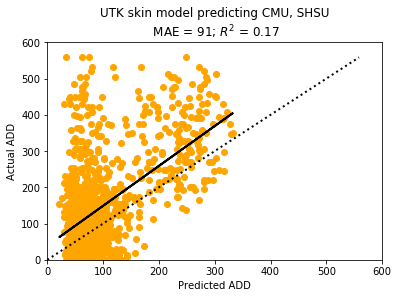

In [196]:
plt.scatter(yhat, Metab_CMU_SHSU_meta.sample_metadata.add_0c, color = 'orange')
lower = np.min(np.concatenate([Metab_CMU_SHSU_meta.sample_metadata.add_0c, yhat]))
upper = np.max(np.concatenate([Metab_CMU_SHSU_meta.sample_metadata.add_0c, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,Metab_CMU_SHSU_meta.sample_metadata.add_0c)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('UTK soil model predicting CMU, SHSU\n MAE = %d; $R^2$ = %.2f' %(round(MAE, 2),round(model_Metab_UTK_rfecv.score(rfecv.transform(Metab_CMU_SHSU_meta.data),y_CMU_SHSU),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/UTK_soil_model_pred_CMU_SHSU.png')